# 1. Import and config

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")  #Load dpu.bit
#If an error is reported, there is a problem with the image 

from dnndk import n2cube
import numpy as np
from numpy import float32
import os
import cv2
import matplotlib.pyplot as plt
import time
import DpuCar
from DpuCar import CommonFunction

# 2. Loading the dataset

In [2]:
KERNEL_CONV="dpuCarModel_0"  #Kernel name
sorts_list = ['mask', 'nomask']  #Classification category, please sort by test set folder
img_size_net = 160  #Enter picture size = 160*160
num_photo=0  #The variable name that records the number of photos in the test set

def load_valid_data(data_path):
#Input image preprocessing function
    label_cnt = 0
    photo_num = 0
    test_images = []
    test_lables = []
    for sort_path in sorts_list:    
        flower_list = os.listdir(data_path + sort_path)
        for img_name in flower_list:
            photo_num += 1
            img_path = data_path + sort_path + "/" + img_name
            img = cv2.imread(img_path)  
            img_scale = cv2.resize(img,(img_size_net, img_size_net), interpolation = cv2.INTER_CUBIC)
            if not img is None:
                test_images.append(img_scale / 255.)
                test_lables.append(label_cnt)
        label_cnt += 1
    print('There are ',label_cnt,' lables' ,'and',photo_num,' photos')
    return test_images, test_lables, photo_num

dataset_valid_path = './test_data/'  #Test data set address
(validSet_images, validSet_lables, num_photo) = load_valid_data(dataset_valid_path)
validSet_images = np.array(validSet_images)
validSet_lables = np.array(validSet_lables)

There are  2  lables and 200  photos


# 3. DPU experiment

## 3.1 Load kernel to DPU

In [3]:
n2cube.dpuOpen()  #Open the dpu switch
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)  #KERNEL_CONV is dpuCarModel_0
DPU_TASK = n2cube.dpuCreateTask(kernel, mode=2)

agent1 = DpuCar.DpuCar(DPU_TASK)  #The DpuCar function in the DpuCar file is called, and the input and output network node names and the size of the input picture are defined

320.0 240.0
30.0


## 3.2 Calculate the accuracy of the test dataset

In [4]:
acc = 0
for ii in range(0,num_photo):
    img1_scale = validSet_images[ii]
    pdt = agent1.dpuPredictSoftmax(img1_scale)  #Custom softmax function
    rel = validSet_lables[ii]
    if(pdt==rel):
        acc += 1
print('acc = ',acc/num_photo*100,'%')

acc =  87.5 %


## 3.3 Test experiment with test_data

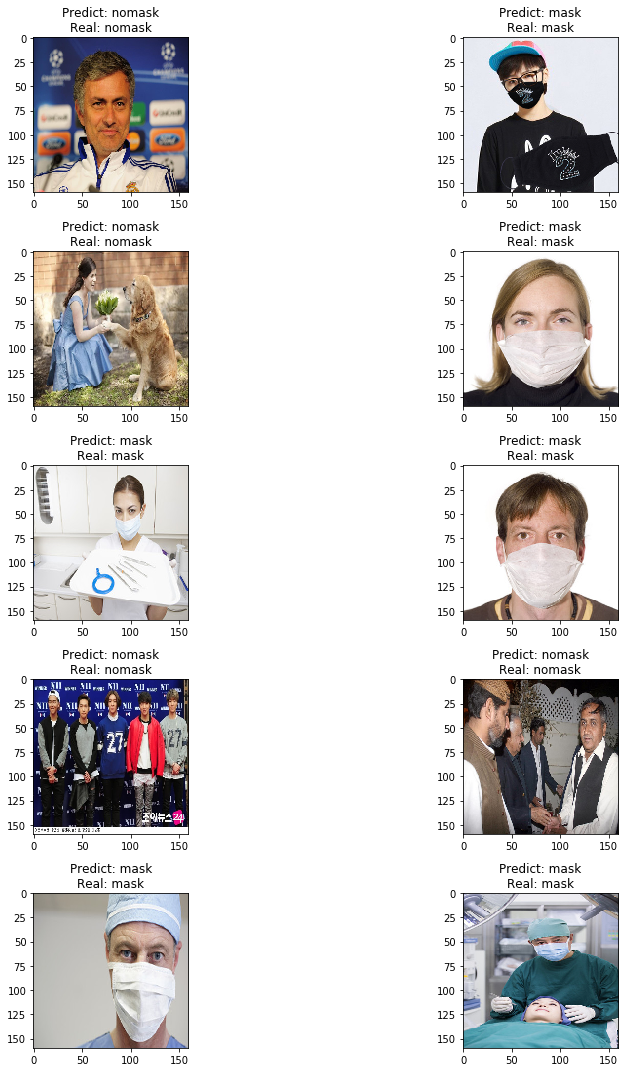

In [5]:
fig, ax = plt.subplots(5, 2)  #Random display behavior 5, listed as 2 a total of ten test set photos
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l = np.random.randint(0, len(validSet_lables))
        img1_scale = validSet_images[l]
        pdt = agent1.dpuPredictSoftmax(img1_scale)  #pdt is the result of neural network recognition
        img1_scale = np.array(img1_scale, dtype='float32')
        ax[i, j].imshow(cv2.cvtColor(img1_scale, cv2.COLOR_BGR2RGB))
        title = "Predict: " + sorts_list[pdt] + "\n" + "Real: " + sorts_list[validSet_lables[l]]
        ax[i, j].set_title(title)
plt.tight_layout()

# 3.4 Test experiment with USB camera

Please connect the USB camera to the Ultra 96 first.

In [6]:
while(1):    
    # clear the output
    CommonFunction.clear_output()
    # read image from camera
    imgMat = agent1.get_image()
    # this image is used for display
    imgShow = cv2.resize(imgMat, (700,460))
    # this image is used for DPU input
    tempImg = cv2.resize(imgMat, (160,160))
    pdt = agent1.dpuPredictSoftmax(tempImg)
    font=cv2.FONT_HERSHEY_SIMPLEX
    if pdt == 1:
        cv2.putText(imgShow,sorts_list[pdt],(10,50), font, 1,(0,0,255),2)
    else:
        cv2.putText(imgShow,sorts_list[pdt],(10,50), font, 1,(255,0,0),2)
    # show result
    CommonFunction.show_img_jupyter(imgShow)
    time.sleep(0.01)

KeyboardInterrupt: 